In [1]:
import shutil
import pathlib
import tempfile
import tensorflow_docs.plots
import tensorflow_docs.modeling

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

from  IPython import display
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
# For tensorboard loggin

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
FEATURES = 28

In [5]:
ds = tf.data.experimental.CsvDataset(gz ,[float(),]*(FEATURES+1), compression_type = "GZIP")

In [6]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


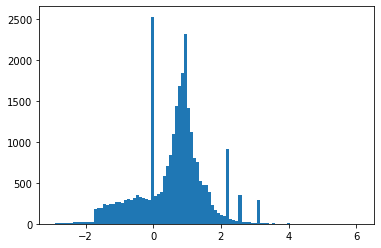

In [8]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [10]:
# Dataset.cache ensures we don't have to reload dataset on each epoch

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [11]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)